In [1]:
using TimeSeries
using Plots
gr()
struct BarInfo
    Id::Int
    High::Float64
    Low::Float64
    Close::Float64
    Weight::Int
end

bars=BarInfo[]
isempty(bars)
push!(bars,BarInfo(1,3.4,3.2,3.3,0))
isempty(bars)
length(bars)


1

In [2]:
function check_downswing(bars::Array{BarInfo,1}, i::Int, h::Float64, l::Float64, c::Float64,limit::Int )::Symbol
    sz=length(bars)
    if(sz==0) return :FirstBar end
    if(bars[end].High >= h && bars[end].Low <= l) return :InSideBar end
    # continue trend
    if(bars[1].Low > l)
        if(sz==1 && bars[1].High < c)  return :SpikeBar end
        return :TrendBar
    end
    # revese trigger
    if(bars[end].High < h)
        if (sz + bars[1].Weight >= limit) return :SignalBar end
    end
    return :ReverseBar  
    
end

check_downswing (generic function with 1 method)

In [3]:
function check_upswing(bars::Array{BarInfo,1}, i::Int, h::Float64, l::Float64, c::Float64,limit::Int )::Symbol
    
    sz=length(bars)
    if(sz==0) return :FirstBar end
    if(bars[end].High >= h && bars[end].Low <= l) return :InSideBar end
    # continue trend
    if(bars[1].High < h)
        if(sz==1 && bars[1].Low > c)  return :SpikeBar end
        return :TrendBar
    end
    
    # revese trigger
    if(bars[end].Low > l)
        if (sz + bars[1].Weight >= limit) return :SignalBar end
    end
    return :ReverseBar
end

check_upswing (generic function with 1 method)

In [50]:
function gann_swing(dir::Int,bars::Array{BarInfo,1}, i::Int, h::Float64, l::Float64, c::Float64, limit::Int)::Tuple{Bool,Int,Float64}

    id = i    
    val = 0.0
    chk = false
    
    if dir == 1
        ans = check_upswing(bars, i, h, l, c ,limit)
    else
        ans = check_downswing(bars, i, h, l, c ,limit)
    end 
    if(ans == :SignalBar)
        chk = true
        id = bars[1].Id
        val = (dir==1) ? bars[1].High : bars[1].Low
    end
    if(ans == :TrendBar || ans == :SpikeBar || ans == :SignalBar)
        resize!(bars,0)
    end        
    if(ans != :InSideBar && ans != :SignalBar)
        w = (ans == :SpikeBar) ? 1 : 0    
        push!(bars, BarInfo(i,h,l,c,w))
    end
    (chk,id,val)    
end

gann_swing (generic function with 1 method)

In [67]:
using MarketData
ta1=AAPL[:Open,:High,:Low,:Close][7900:8075]

176×4 TimeArray{Float64,2,Date,Array{Float64,2}} 2012-04-05 to 2012-12-17
│            │ Open   │ High   │ Low    │ Close  │
├────────────┼────────┼────────┼────────┼────────┤
│ 2012-04-05 │ 626.98 │ 634.66 │ 623.4  │ 633.68 │
│ 2012-04-09 │ 626.13 │ 639.84 │ 625.3  │ 636.23 │
│ 2012-04-10 │ 639.93 │ 644.0  │ 626.0  │ 628.44 │
│ 2012-04-11 │ 636.2  │ 636.87 │ 623.34 │ 626.2  │
│ 2012-04-12 │ 625.0  │ 631.33 │ 620.5  │ 622.77 │
│ 2012-04-13 │ 624.11 │ 624.7  │ 603.51 │ 605.23 │
│ 2012-04-16 │ 610.06 │ 610.28 │ 578.25 │ 580.13 │
│ 2012-04-17 │ 578.94 │ 610.0  │ 571.91 │ 609.7  │
│ 2012-04-18 │ 613.72 │ 620.25 │ 602.71 │ 608.34 │
│ 2012-04-19 │ 600.22 │ 604.73 │ 584.52 │ 587.44 │
│ 2012-04-20 │ 591.38 │ 594.62 │ 570.42 │ 572.98 │
│ 2012-04-23 │ 570.61 │ 576.67 │ 556.62 │ 571.7  │
   ⋮
│ 2012-12-03 │ 593.65 │ 594.59 │ 585.5  │ 586.19 │
│ 2012-12-04 │ 581.8  │ 581.8  │ 572.13 │ 575.85 │
│ 2012-12-05 │ 568.91 │ 569.25 │ 538.77 │ 538.79 │
│ 2012-12-06 │ 528.94 │ 553.31 │ 518.63 │ 547.24 │
│ 2

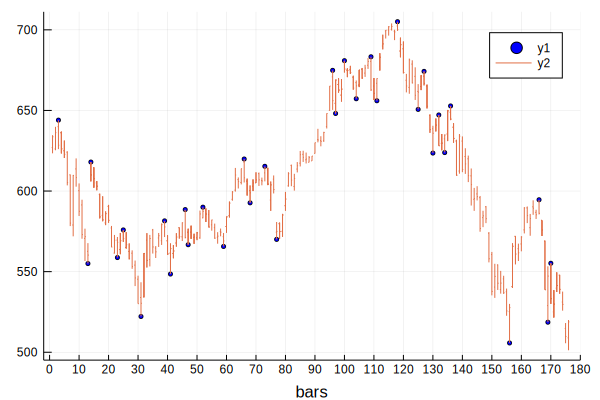

In [68]:
# bars = BarInfo[]
dir=1
y= OHLC[]
x=Int[]
g_x=Int[]
g_y=Float64[]
sz=length(ta1)
i=1
while(i<=sz)
    o = values(ta1[:Open][i])[1]
    h = values(ta1[:High][i])[1]
    l = values(ta1[:Low][i])[1]
    c = values(ta1[:Close][i])[1]
    push!(y,OHLC(o,h,l,c))
    push!(x,i)

    if(isempty(bars))        
        push!(bars, BarInfo(i,h,l,c,0))
        continue
    end
    
    (chk,id,val) = gann_swing(dir, bars, i, h, l ,c,2)
    if (chk)
        dir=-dir
        push!(g_y,val)
        push!(g_x,id)
        i=id
    else
        if(!isempty(bars))
        #        push!(g_y,(dir==1) ? bars[1].High : bars[1].Low)
        #        push!(g_x,bars[1].Id)
        end
    end
    i+=1
end    


Plots.scatter(g_x,g_y,markersize=2, c=:blue,xaxis=("bars", (-2, 180), 0:10:180))
Plots.ohlc!(x,y)

